In [1]:
from dotenv import load_dotenv
from metagame import TradingClient
import os

load_dotenv()

client = TradingClient(
    api_url=os.environ["API_URL"],
    jwt=os.environ["JWT"],
    act_as=int(os.environ["ACT_AS"]),
)

In [7]:
import pandas as pd

def get_best_bid_offer(market_name: str):
    state = client.state()
    market_id = state.market_name_to_id.get(market_name)
    if market_id is None:
        return pd.Series()
    bids = state.markets[market_id].bids
    offers = state.markets[market_id].offers
    return pd.Series({
        "bid": bids[0].price if bids else None,
        "offer": offers[0].price if offers else None
    })
get_best_bid_offer("At 6PM Saturday, resolves to 20 if I believe a camp participant has >=4000 clips")

bid      0.0
offer    NaN
dtype: float64

In [3]:
def get_market_trades(market_name: str):
    state = client.state()
    market_id = state.market_name_to_id.get(market_name)    
    if market_id is None:
        return pd.DataFrame()

    if not state.markets[market_id].hasFullTradeHistory:
        client.get_full_trade_history(market_id)
        state = client.state()

    trades = state.markets[market_id].trades
    if not trades:
        return pd.DataFrame()
    df = pd.DataFrame(trades).set_index("id")
    df["buyer"] = df["buyer_id"].map(lambda x: state.accounts[x].name)
    df["seller"] = df["seller_id"].map(lambda x: state.accounts[x].name)
    return df.drop(columns=["market_id", "buyer_id", "seller_id"])


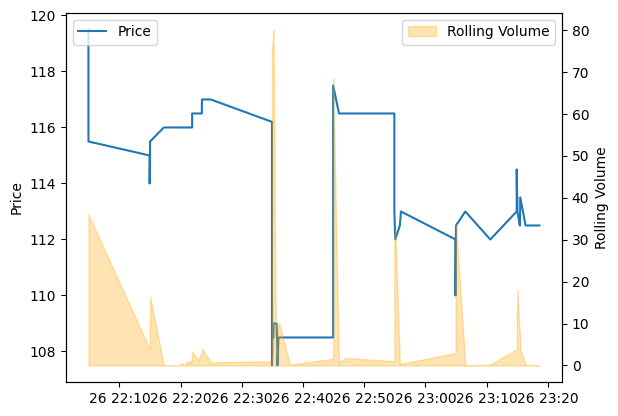

In [4]:
from IPython.display import clear_output, display
from matplotlib import pyplot as plt
from datetime import timedelta

try:
    while True:
        display(get_best_bid_offer("test_bond"))
        trades = get_market_trades("alpha_tradewars").set_index("transaction_timestamp")
        if not trades.empty:
            fig, ax = plt.subplots()
            ax.plot(trades.price, label="Price")
            ax.set_ylabel("Price")
            twin = ax.twinx()
            rolling_volume = trades["size"].rolling(timedelta(minutes=0.5)).sum()
            twin.fill_between(trades.index, rolling_volume, color="orange", alpha=0.3, label="Rolling Volume")
            twin.set_ylabel("Rolling Volume")
            ax.legend(loc='upper left')
            twin.legend(loc='upper right')
            display(fig)
        client.wait_portfolio_update()
        clear_output(wait=True)
except KeyboardInterrupt:
    clear_output(wait=True)

In [5]:
from metagame.websocket_api import Order

def order_size_at_transaction(order: Order, transaction_id: int) -> float:
    for size in reversed(order.sizes):
        if size.transaction_id <= transaction_id:
            return size.size
    return 0.0

def get_bbo_history(market_name: str):
    state = client.state()
    market_id = state.market_name_to_id.get(market_name)    
    if market_id is None:
        return pd.DataFrame()

    if not state.markets[market_id].hasFullOrderHistory:
        client.get_full_order_history(market_id)
        state = client.state()

    orders = state.markets[market_id].orders
    bids = state.markets[market_id].bids
    offers = state.markets[market_id].offers
    if not orders:
        return pd.DataFrame()

    transaction_timestamp_by_id = {size.transaction_id: size.transaction_timestamp for o in orders for size in o.sizes}
    transaction_ids = sorted(transaction_timestamp_by_id)
    transaction_timestamps = [
        transaction_timestamp_by_id[t]
        for t in transaction_ids
    ]
    best_bids = [
        next((b for b in bids if order_size_at_transaction(b, t) > 0.0), None)
        for t in transaction_ids
    ]
    best_offers = [
        next((o for o in offers if order_size_at_transaction(o, t) > 0.0), None)
        for t in transaction_ids
    ]
    df = pd.DataFrame({
        "transaction_id": transaction_ids,
        "timestamp": transaction_timestamps,
        "best_bid_price": [b.price if b is not None else None for b in best_bids],
        "best_bid_size": [
            order_size_at_transaction(b, t) if b is not None else None
            for b, t in zip(best_bids, transaction_ids)
        ],
        "best_offer_price": [o.price if o is not None else None for o in best_offers],
        "best_offer_size": [
            order_size_at_transaction(o, t) if o is not None else None
            for o, t in zip(best_offers, transaction_ids)
        ]
    })
    return df.drop_duplicates(
        subset=["best_bid_price", "best_bid_size", "best_offer_price", "best_offer_size"]
    ).set_index("transaction_id")

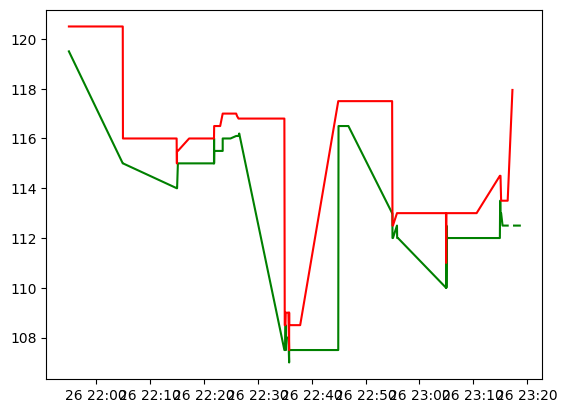

In [6]:
bbo_history = get_bbo_history("alpha_tradewars")
fig, ax = plt.subplots()
_ = ax.plot(bbo_history.timestamp, bbo_history.best_bid_price, color="green")
_ = ax.plot(bbo_history.timestamp, bbo_history.best_offer_price, color="red")

In [7]:
def get_market_positions(market_name: str):
    df = get_market_trades(market_name)
    if df.empty:
        return pd.DataFrame()
    return pd.concat([
        df.groupby("buyer")["size"].sum(),
        -df.groupby("seller")["size"].sum()
    ]).groupby(level=0).sum()

def get_multiple_market_positions(market_names: list[str]):
    return pd.DataFrame({market: get_market_positions(market) for market in market_names}).fillna(0)

In [3]:
state = client.state()
account_id_to_name = {account.id: account.name for account in state.accounts}
print(account_id_to_name)


{0: 'Hidden', 1: 'Ross Rheingans-Yoo', 2: 'Nicholas Charette', 3: 'Yoav Tzfati', 4: 'Mark Rychnovsky', 5: 'Ricki Heicklen', 6: 'Tanmay Khale', 7: 'Nicholas Charette-82b3972', 8: 'Matt Connor', 9: 'Elizabeth Garrett', 10: 'Bogdan Enache', 11: 'Rachel Weinberg', 12: 'Andy Rapista', 13: 'Ethan Anderson', 14: 'Neal Shrestha', 15: 'Tony Deng', 16: 'Paul Yea', 17: 'Sameer Bhatti', 18: 'Kasra Danesh', 19: 'Mihkel Viires', 20: 'darsh jain', 21: 'Michael Sienko', 22: 'alexander ?', 23: 'Sub-acct-one', 24: 'TA', 25: 'Alt', 26: 'Beanbag', 27: "Kasra's alt", 28: 'thegoats', 29: 'test share ', 30: 'R&B', 31: 'test share', 32: 'TonyMichael', 33: 'Test#1', 34: 'DK2', 35: 'Noa Nabeshima', 36: 'Robert', 37: 'alt', 38: 'HAL', 39: 'empty', 40: 'team-b', 41: 'thursday_5', 42: 'thursday_3', 43: 'thursday_0', 44: 'thursday_6', 45: 'thursday_1', 46: 'thursday_4', 47: 'thursday_2', 48: 'Alice', 49: 'th_0', 50: 'th_1', 51: 'th_2', 52: 'th_3', 53: 'th_4', 54: 'th_mark', 55: 'th_alice', 56: 'th_eve_2', 57: 'th_e